In [118]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pl.Config.set_tbl_rows(20)      # Increase max rows (default is 10)
pl.Config.set_tbl_cols(20)        # Increase max columns (default is 10)

polars.config.Config

In [119]:
# Load the Parquet file into a Polars DataFrame
silver_df = pl.read_parquet("data/silver_df.parquet")

# Drop unnecessary columns
silver_df = silver_df.drop(["itemid", "label", "abbreviation"])

In [120]:
# PREPARATION TO MERGE VALUE AND VALUENUM

# try casting 'value' to Float64
casted_value_to_f64 = silver_df.select(
    pl.col("value").cast(pl.Float64, strict=False).alias("value_as_f64")
)["value_as_f64"]
silver_df = silver_df.with_columns(casted_value_to_f64) # save as new column

# Keep valuenum, otherwise check if casted value exists
silver_df = silver_df.with_columns([
    pl.when(pl.col("valuenum").is_not_null())
      .then(pl.col("valuenum"))
      .otherwise(pl.col("value_as_f64"))
      .alias("valuenum"),

    # keep value only if string
    pl.when(
        (pl.col("valuenum").is_not_null()) |
        (pl.col("value_as_f64").is_not_null())
    ).then(pl.lit(None))
     .otherwise(pl.col("value"))
     .alias("value")
])

# drop the temporary column
silver_df = silver_df.drop("value_as_f64")

In [121]:
# Adjusting valueuom and value columns based on concept_id
silver_df = silver_df.with_columns([
    pl.when(pl.col("concept_id") == 45883663).then(pl.lit("bool"))
      .when(pl.col("concept_id") == 4265453).then(pl.lit("year"))
      .when(pl.col("concept_id") == 4135376).then(pl.lit("gender"))
      .otherwise(pl.col("valueuom")).alias("valueuom"),

    pl.when(pl.col("concept_id") == 45883663)
      .then(
          pl.col("value").cast(str).str.contains("nursing").fill_null(False)
      )
      .otherwise(pl.col("value"))
      .alias("value")
])

In [122]:
# Have a look at the unique concepts
unique_concepts = silver_df.select(["concept_id", "concept_name","valueuom"]).unique()

print(unique_concepts)

shape: (10, 3)
┌────────────┬─────────────────────────────────┬──────────┐
│ concept_id ┆ concept_name                    ┆ valueuom │
│ ---        ┆ ---                             ┆ ---      │
│ i64        ┆ str                             ┆ str      │
╞════════════╪═════════════════════════════════╪══════════╡
│ 36716470   ┆ Temperature                     ┆ °C       │
│ 4152194    ┆ Systolic blood pressure         ┆ mmHg     │
│ 4097430    ┆ Sodium measurement              ┆ mEq/L    │
│ 4265453    ┆ Age                             ┆ year     │
│ 4017361    ┆ Blood urea nitrogen measuremen… ┆ mg/dL    │
│ 4135376    ┆ Gender                          ┆ gender   │
│ 4149519    ┆ Glucose measurement             ┆ mg/dL    │
│ 4151358    ┆ Hematocrit determination        ┆ %        │
│ 4097822    ┆ pH measurement, arterial        ┆ units    │
│ 45883663   ┆ Nursing Home                    ┆ bool     │
└────────────┴─────────────────────────────────┴──────────┘


In [123]:
# ALL TIME AGGREGATION

# 1. Mittelwert von valuenum berechnen
valuenum_means = (
    silver_df
    .group_by(["subject_id", "hadm_id", "stay_id", "concept_name"])
    .agg(pl.col("valuenum").mean().alias("mean_val"))
)

# 2. Ersten nicht-null Wert aus value erfassen
first_value_fallback = (
    silver_df
    .filter(pl.col("value").is_not_null())
    .group_by(["subject_id", "hadm_id", "stay_id", "concept_name"])
    .agg(pl.col("value").first().alias("value_fallback"))
)

# 3. Tabellen mergen
merged = valuenum_means.join(
    first_value_fallback,
    on=["subject_id", "hadm_id", "stay_id", "concept_name"],
    how="left"
)

# 4. Wenn mean_val null ist → ersatzweise value_fallback verwenden
result = merged.with_columns([
    pl.when(pl.col("mean_val").is_not_null())
      .then(pl.col("mean_val").round(2))  # ⬅️ round only numeric mean values
      .otherwise(pl.col("value_fallback"))
      .alias("final_value")
])

# 5. Pivot: wide format (concept_name → Spalten)
gold_df = (
    result
    .select(["subject_id", "hadm_id", "stay_id", "concept_name", "final_value"])
    .pivot(
        index=["subject_id", "hadm_id", "stay_id"],
        on="concept_name",
        values="final_value"
    )
)

print(gold_df.columns)
print(gold_df)

['subject_id', 'hadm_id', 'stay_id', 'Nursing Home', 'Age', 'Hematocrit determination', 'Glucose measurement', 'Sodium measurement', 'Gender', 'pH measurement, arterial', 'Temperature', 'Blood urea nitrogen measurement', 'Systolic blood pressure']
shape: (7, 13)
┌─────┬─────┬─────┬────────┬──────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sub ┆ had ┆ sta ┆ Nursin ┆ Age  ┆ Hemato ┆ Gluco ┆ Sodiu ┆ Gende ┆ pH    ┆ Tempe ┆ Blood ┆ Systo │
│ jec ┆ m_i ┆ y_i ┆ g Home ┆ ---  ┆ crit   ┆ se    ┆ m mea ┆ r     ┆ measu ┆ ratur ┆ urea  ┆ lic   │
│ t_i ┆ d   ┆ d   ┆ ---    ┆ str  ┆ determ ┆ measu ┆ surem ┆ ---   ┆ remen ┆ e     ┆ nitro ┆ blood │
│ d   ┆ --- ┆ --- ┆ str    ┆      ┆ inatio ┆ remen ┆ ent   ┆ str   ┆ t,    ┆ ---   ┆ gen   ┆ press │
│ --- ┆ i64 ┆ i64 ┆        ┆      ┆ n      ┆ t     ┆ ---   ┆       ┆ arter ┆ str   ┆ measu ┆ ure   │
│ i64 ┆     ┆     ┆        ┆      ┆ ---    ┆ ---   ┆ str   ┆       ┆ ial   ┆       ┆ remen ┆ ---   │
│     ┆     ┆     ┆        ┆  

In [124]:
# DAY BASED AGGREGATION

# Parameter: Aggregationsintervall in Tagen
interval_days = 1

# 1. charttime in datetime casten
df = silver_df.with_columns([
    pl.col("charttime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")])

# 2. Früheste charttime pro Fall (subj/hadm/stay)
base_times = (
    df
    .group_by(["subject_id", "hadm_id", "stay_id"])
    .agg(pl.col("charttime").min().alias("base_time"))
)

# 3. Verbinden mit Originaldaten, um base_time verfügbar zu machen
df = df.join(base_times, on=["subject_id", "hadm_id", "stay_id"], how="left")

# 4. Zeitfenster berechnen: (charttime - base_time).days // interval_days
df = df.with_columns([
    (((pl.col("charttime") - pl.col("base_time")).dt.total_days()) // interval_days)
    .cast(pl.Int64)
    .alias("window_id")
])
all_windows = (
    df.select(["subject_id", "hadm_id", "stay_id", "window_id"])
    .unique()
)

# 5. numerische Werte extrahieren für Aggregation
df = df.with_columns([
    pl.when(pl.col("valuenum").is_not_null())
      .then(pl.col("valuenum"))
      .otherwise(
          pl.when(pl.col("value").cast(pl.Float64, strict=False).is_not_null())
            .then(pl.col("value").cast(pl.Float64, strict=False))
      )
      .alias("numeric_value")
])

# 6a. Aggregation: Mittelwert für numerische Werte
mean_numeric = (
    df
    .group_by(["subject_id", "hadm_id", "stay_id", "window_id", "concept_name"])
    .agg(pl.col("numeric_value").mean().round(2).alias("mean_value"))
)

# 6b. Fallback: erster String-Wert aus value, wenn keine numeric_value vorhanden
fallback_value = (
    df
    .filter(pl.col("valuenum").is_null())
    .group_by(["subject_id", "hadm_id", "stay_id", "window_id", "concept_name"])
    .agg(pl.col("value").first().alias("fallback_value"))
)


# 7. Join der beiden Aggregationsergebnisse
merged = mean_numeric.join(
    fallback_value,
    on=["subject_id", "hadm_id", "stay_id", "window_id", "concept_name"],
    how='full', coalesce=True
)

# 8. Endwert wählen: mean_value falls vorhanden, sonst fallback_value
final = merged.with_columns([
    pl.when(pl.col("mean_value").is_not_null())
      .then(pl.col("mean_value").cast(pl.Utf8))  # cast float to string for consistency
      .otherwise(pl.col("fallback_value"))
      .alias("final_value")
])
final_filled = (
    all_windows
    .join(final, on=["subject_id", "hadm_id", "stay_id", "window_id"], how="left")
)

# 9. Pivot ins Wide-Format
days_gold_df = (
    final_filled
    .pivot(
        index=["subject_id", "hadm_id", "stay_id", "window_id"],
        on="concept_name",
        values="final_value"
    )
    .sort(["subject_id", "hadm_id", "stay_id", "window_id"])
)

# All columns to be forward filled
fill_cols = [col for col in days_gold_df.columns if col not in {"subject_id", "hadm_id", "stay_id", "window_id"}]

# Apply forward fill within each group
days_gold_df = days_gold_df.with_columns([
    pl.col(col).fill_null(strategy="forward").over(["subject_id", "hadm_id", "stay_id"])
    for col in fill_cols
])

print(days_gold_df)

shape: (67, 14)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┬────────┬───────┬───────┬──────┬───────┬───────┐
│ sub ┆ had ┆ sta ┆ win ┆ Blo ┆ Sys ┆ Glu ┆ Hemato ┆ Sodium ┆ pH    ┆ Gende ┆ Age  ┆ Nursi ┆ Tempe │
│ jec ┆ m_i ┆ y_i ┆ dow ┆ od  ┆ tol ┆ cos ┆ crit   ┆ measur ┆ measu ┆ r     ┆ ---  ┆ ng    ┆ ratur │
│ t_i ┆ d   ┆ d   ┆ _id ┆ ure ┆ ic  ┆ e   ┆ determ ┆ ement  ┆ remen ┆ ---   ┆ str  ┆ Home  ┆ e     │
│ d   ┆ --- ┆ --- ┆ --- ┆ a   ┆ blo ┆ mea ┆ inatio ┆ ---    ┆ t,    ┆ str   ┆      ┆ ---   ┆ ---   │
│ --- ┆ i64 ┆ i64 ┆ i64 ┆ nit ┆ od  ┆ sur ┆ n      ┆ str    ┆ arter ┆       ┆      ┆ str   ┆ str   │
│ i64 ┆     ┆     ┆     ┆ rog ┆ pre ┆ eme ┆ ---    ┆        ┆ ial   ┆       ┆      ┆       ┆       │
│     ┆     ┆     ┆     ┆ en  ┆ ssu ┆ nt  ┆ str    ┆        ┆ ---   ┆       ┆      ┆       ┆       │
│     ┆     ┆     ┆     ┆ mea ┆ re  ┆ --- ┆        ┆        ┆ str   ┆       ┆      ┆       ┆       │
│     ┆     ┆     ┆     ┆ sur ┆ --- ┆ str ┆        ┆        ┆       ┆      

In [125]:
def calculate_curb65(df: pl.DataFrame) -> pl.DataFrame:
    # Spalten als Float casten (str → float), fehlerhafte Werte zu null machen
    df = df.with_columns([
        pl.col("Systolic blood pressure").cast(pl.Float64, strict=False).fill_null(0).alias("sbp"),
        pl.col("Age").cast(pl.Float64, strict=False).fill_null(0).alias("age"),
        pl.col("Blood urea nitrogen measurement").cast(pl.Float64, strict=False).fill_null(0).alias("bun"),
    ])
    
    # Punkte berechnen
    df = df.with_columns([
        # Start bei 0 + Bedingungen addieren
        (
            (pl.col("sbp") < 90).cast(pl.Int64) +
            (pl.col("age") >= 65).cast(pl.Int64) +
            (pl.col("bun") > 20).cast(pl.Int64)
        ).alias("CURB-65")
    ])
    
    # Optional: Hilfsspalten entfernen
    df = df.drop(["sbp", "age", "bun"])

    return df

In [126]:
def calculate_psi_port(df: pl.DataFrame) -> pl.DataFrame:
    # Spalten casten (numerisch) und Nullwerte ersetzen
    df = df.with_columns([
        pl.col("Systolic blood pressure").cast(pl.Float64, strict=False).fill_null(0).alias("sbp"),
        pl.col("Temperature").cast(pl.Float64, strict=False).fill_null(0).alias("temp"),
        pl.col("pH measurement, arterial").cast(pl.Float64, strict=False).fill_null(0).alias("ph"),
        pl.col("Blood urea nitrogen measurement").cast(pl.Float64, strict=False).fill_null(0).alias("bun"),
        pl.col("Sodium measurement").cast(pl.Float64, strict=False).fill_null(0).alias("sodium"),
        pl.col("Glucose measurement").cast(pl.Float64, strict=False).fill_null(0).alias("glucose"),
        pl.col("Hematocrit determination").cast(pl.Float64, strict=False).fill_null(0).alias("hematocrit"),
        (pl.col("Nursing Home").cast(pl.Utf8).str.to_lowercase().eq("true")).alias("nursing_home"),
        pl.col("Gender").str.to_lowercase().alias("gender")
    ])

    # Score berechnen
    df = df.with_columns([
        (
            (pl.col("nursing_home") * 10) +
            ((pl.col("gender") == "f").cast(pl.Int64) * (-10)) +
            ((pl.col("sbp") < 90).cast(pl.Int64) * 20) +
            (((pl.col("temp") < 35) | (pl.col("temp") >= 40)).cast(pl.Int64) * 15) +
            ((pl.col("ph") < 7.35).cast(pl.Int64) * 30) +
            ((pl.col("bun") >= 230).cast(pl.Int64) * 20) +
            ((pl.col("sodium") < 130).cast(pl.Int64) * 20) +
            ((pl.col("glucose") >= 250).cast(pl.Int64) * 10) +
            ((pl.col("hematocrit") < 30).cast(pl.Int64) * 10) 
        ).alias("PSI/PORT")
    ])

    # Hilfsspalten entfernen
    df = df.drop([
        "sbp", "temp", "ph", "bun", "sodium", "glucose", "hematocrit", "nursing_home", "gender"
    ])

    return df

In [127]:
# Calculate CURB-65 and PSI/PORT scores
days_gold_df = calculate_curb65(days_gold_df)
days_gold_df = calculate_psi_port(days_gold_df)

print(days_gold_df.columns)
print(days_gold_df)

['subject_id', 'hadm_id', 'stay_id', 'window_id', 'Blood urea nitrogen measurement', 'Systolic blood pressure', 'Glucose measurement', 'Hematocrit determination', 'Sodium measurement', 'pH measurement, arterial', 'Gender', 'Age', 'Nursing Home', 'Temperature', 'CURB-65', 'PSI/PORT']
shape: (67, 16)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┐
│ sub ┆ had ┆ sta ┆ win ┆ Blo ┆ Sys ┆ Glu ┆ Hem ┆ Sod ┆ pH  ┆ Gen ┆ Age ┆ Nur ┆ Tem ┆ CUR ┆ PSI/PO │
│ jec ┆ m_i ┆ y_i ┆ dow ┆ od  ┆ tol ┆ cos ┆ ato ┆ ium ┆ mea ┆ der ┆ --- ┆ sin ┆ per ┆ B-6 ┆ RT     │
│ t_i ┆ d   ┆ d   ┆ _id ┆ ure ┆ ic  ┆ e   ┆ cri ┆ mea ┆ sur ┆ --- ┆ str ┆ g   ┆ atu ┆ 5   ┆ ---    │
│ d   ┆ --- ┆ --- ┆ --- ┆ a   ┆ blo ┆ mea ┆ t   ┆ sur ┆ eme ┆ str ┆     ┆ Hom ┆ re  ┆ --- ┆ i64    │
│ --- ┆ i64 ┆ i64 ┆ i64 ┆ nit ┆ od  ┆ sur ┆ det ┆ eme ┆ nt, ┆     ┆     ┆ e   ┆ --- ┆ i64 ┆        │
│ i64 ┆     ┆     ┆     ┆ rog ┆ pre ┆ eme ┆ erm ┆ nt  ┆ art ┆     ┆     ┆ --- ┆ str ┆     ┆   

In [128]:
# Save as parquet file
days_gold_df.write_parquet("data/gold_df.parquet")

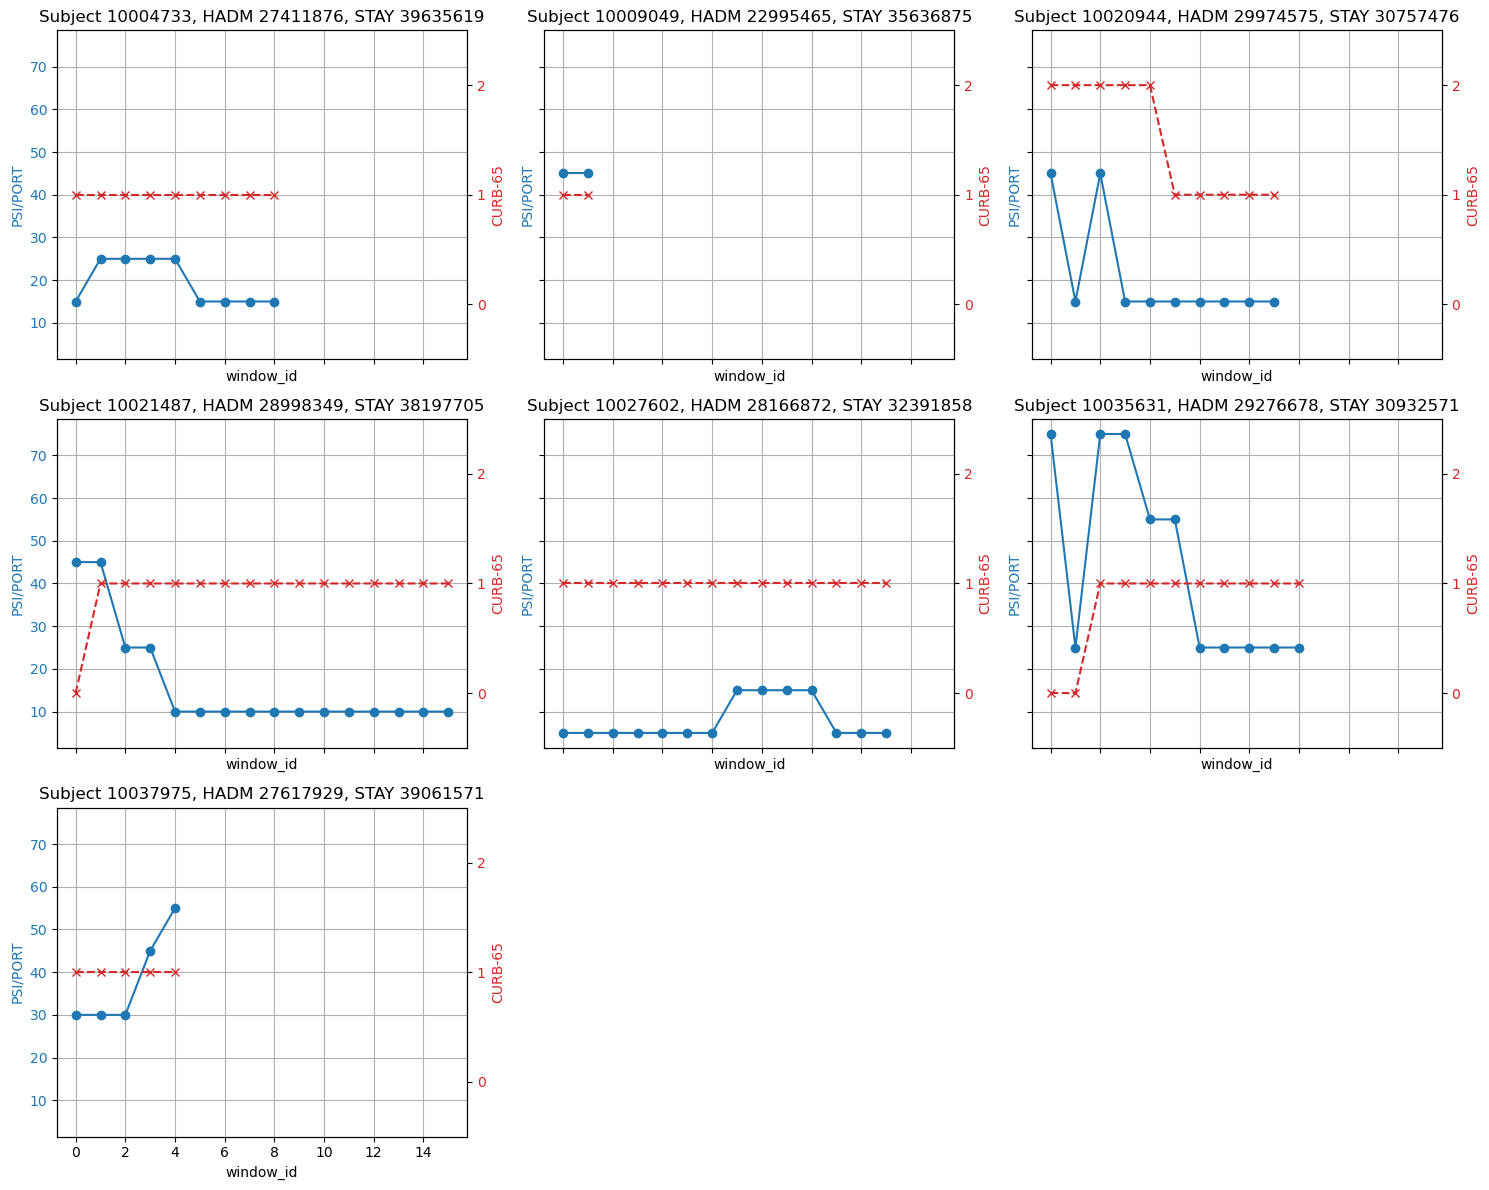

In [ ]:
pdf = days_gold_df.to_pandas()
grouped = pdf.groupby(['subject_id', 'hadm_id', 'stay_id'])

n = len(grouped)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True, sharey=True)
axes = axes.flatten()

# Sammle alle CURB-65 Werte, um globale Min/Max für die gemeinsame Skalierung zu bestimmen
all_curb65 = pdf['CURB-65']
curb_min = all_curb65.min()
curb_max = all_curb65.max()

for i, ((subject_id, hadm_id, stay_id), group) in enumerate(grouped):
    group_sorted = group.sort_values('window_id')
    
    ax1 = axes[i]
    ax1.plot(group_sorted['window_id'], group_sorted['PSI/PORT'], marker='o', color='tab:blue', label='PSI/PORT')
    ax1.set_title(f'Subject {subject_id}, HADM {hadm_id}, STAY {stay_id}')
    ax1.set_xlabel('window_id')
    ax1.set_ylabel('PSI/PORT', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(group_sorted['window_id'], group_sorted['CURB-65'], marker='x', linestyle='--', color='tab:red', label='CURB-65')
    ax2.set_ylabel('CURB-65', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Setze für alle CURB-65-Achsen dieselbe y-Lim und Integer-Ticks
    ax2.set_ylim(curb_min - 0.5, curb_max + 0.5)  # etwas Puffer
    ax2.set_yticks(np.arange(curb_min, curb_max + 1, 1))  # Integer-Ticks

# Nicht verwendete Subplots entfernen
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

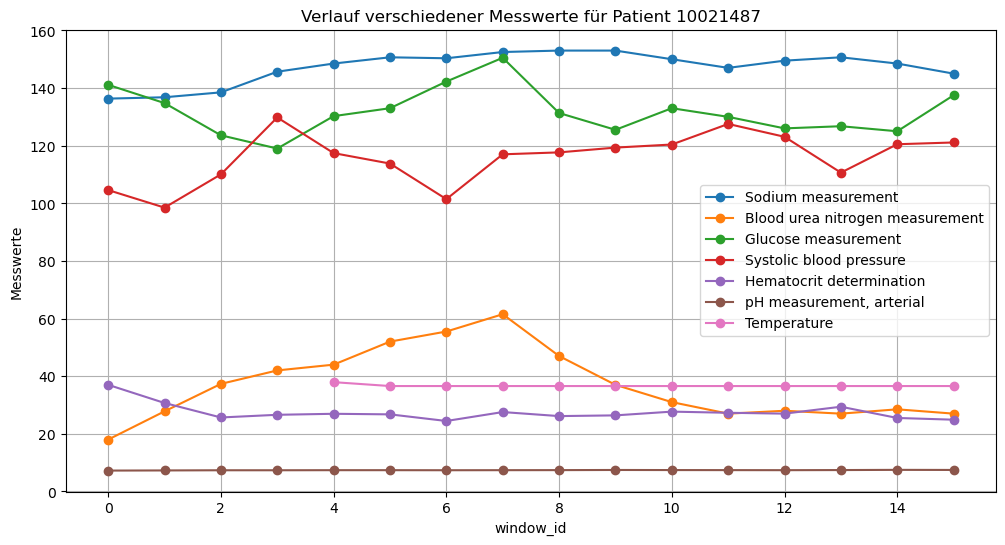

In [ ]:
patient_df = days_gold_df.filter(
    (pl.col('subject_id') == 10021487) & 
    (pl.col('hadm_id') == 28998349) & 
    (pl.col('stay_id') == 38197705)
).to_pandas()

patient_df = patient_df.sort_values('window_id')

columns_to_plot = [
    'Sodium measurement',
    'Blood urea nitrogen measurement',
    'Glucose measurement',
    'Systolic blood pressure',
    'Hematocrit determination',
    'pH measurement, arterial',
    'Temperature'
]

# Fehlende Werte behandeln: "none" in NaN umwandeln und zu numerisch konvertieren
for col in columns_to_plot:
    patient_df[col] = patient_df[col].replace('none', np.nan)
    patient_df[col] = pd.to_numeric(patient_df[col], errors='coerce')

plt.figure(figsize=(12, 6))

for col in columns_to_plot:
    # Prüfe, ob es mindestens einen validen Wert gibt
    if patient_df[col].notna().any():
        plt.plot(patient_df['window_id'], patient_df[col], marker='o', label=col)

plt.title('Verlauf verschiedener Messwerte für Patient 10021487')
plt.xlabel('window_id')
plt.ylabel('Messwerte')
plt.legend(loc='center right')
plt.grid(True)
plt.show()